In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import tree

import utils

from utils import local_data
from utils import window
from utils import Scale, give_error
from utils import smooth_signal
from utils import generate_and_avaliate_model
from utils import location_station, find_set_sunrise, find_set_sunset

%matplotlib inline
warnings.filterwarnings('ignore')

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df = pd.read_pickle('./data/sj2_analise.pkl')

In [3]:
df.head()

,vtec,vtec_dt,vtec_dt2,gvtec1,gvtec1_dt,gvtec2,gvtec2_dt,s4
2013-12-01 03:30:00,33.624428,-0.428246,-0.020502,-3.216613,0.002355,1.826065,1.991653,0.163334
2013-12-01 03:40:00,33.205025,-0.546589,-0.118343,-3.122300,0.130198,4.588494,2.530373,0.165397
2013-12-01 03:50:00,32.539631,-0.772594,-0.226005,-2.810556,0.280756,7.786990,2.862830,0.168683
2013-12-01 04:00:00,31.469337,-1.082859,-0.310265,-2.320938,0.399753,10.972091,2.894375,0.173552
2013-12-01 04:10:00,29.995466,-1.429647,-0.346788,-1.764129,0.443303,13.734955,2.621609,0.178917


### (1) Estimação de s4 com vtec

Error for the time series sample:
O erro quadrático médio foi: 0.006287
O erro quadrático total foi: 2.822446
O maior erro por previsão foi: 0.586189
O erro relativo foi: 14.293789%
O número de verdadeiros negativos foi: 999
O número de verdadeiros positivos foi: 50
O número de falsos negativos foi: 103
O número de falsos positivos foi: 115
O POD foi: 0.326797
O FAR foi: 0.696970
A ACC foi: 0.827940
O kappa foi: 0.067681
precission: 0.303030
recal: 0.326797
f1: 0.314465


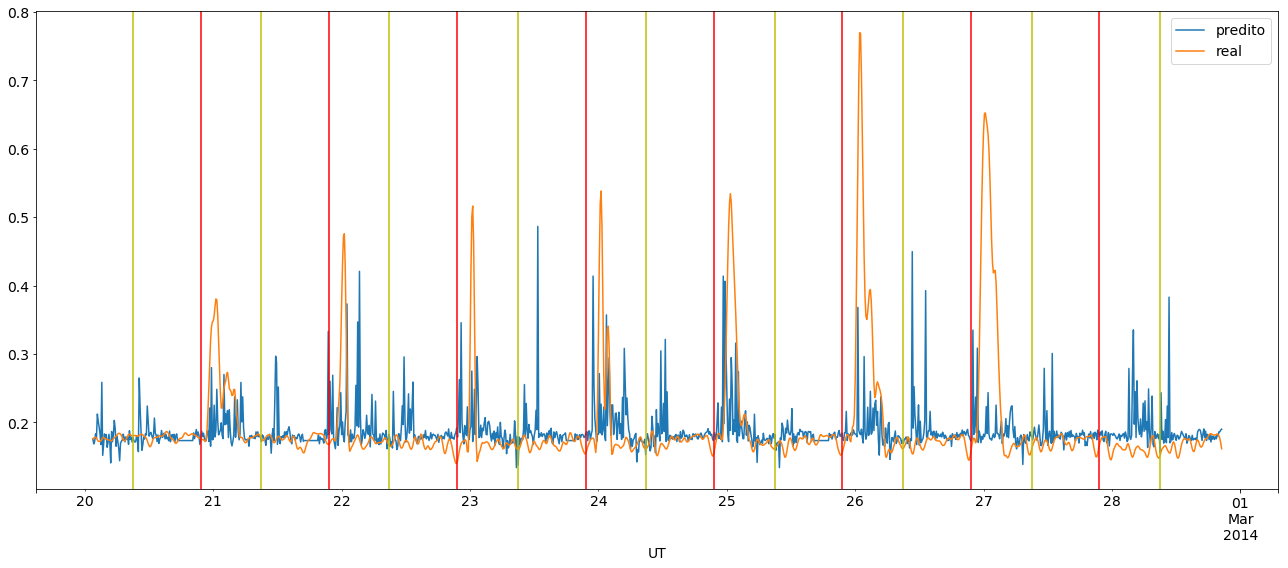

In [4]:
instances_set = ['vtec']
dict_error = generate_and_avaliate_model(df=df,
                                         instances_set=instances_set,
                                         target='s4')

### (2) Estimação de s4 com vtec, vtec_dt e vtec_dt2

Error for the time series sample:
O erro quadrático médio foi: 0.004883
O erro quadrático total foi: 2.487320
O maior erro por previsão foi: 0.522827
O erro relativo foi: 14.968134%
O número de verdadeiros negativos foi: 943
O número de verdadeiros positivos foi: 111
O número de falsos negativos foi: 42
O número de falsos positivos foi: 171
O POD foi: 0.725490
O FAR foi: 0.606383
A ACC foi: 0.831886
O kappa foi: 0.036496
precission: 0.393617
recal: 0.725490
f1: 0.510345


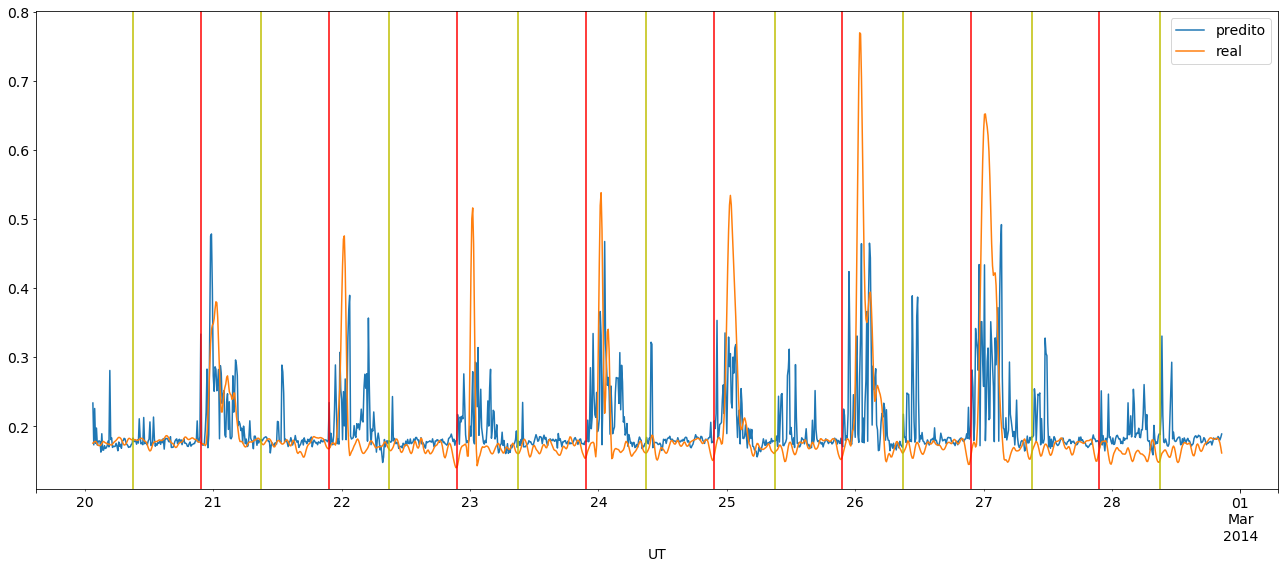

In [5]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2']
dict_error = generate_and_avaliate_model(df=df,
                                         instances_set=instances_set,
                                         target='s4')

### (3) Estimação de S4 com vtec, gvtec1 e gvtec2

Error for the time series sample:
O erro quadrático médio foi: 0.005554
O erro quadrático total foi: 2.652670
O maior erro por previsão foi: 0.577887
O erro relativo foi: 14.088566%
O número de verdadeiros negativos foi: 965
O número de verdadeiros positivos foi: 91
O número de falsos negativos foi: 62
O número de falsos positivos foi: 149
O POD foi: 0.594771
O FAR foi: 0.620833
A ACC foi: 0.833465
O kappa foi: 0.045717
precission: 0.379167
recal: 0.594771
f1: 0.463104


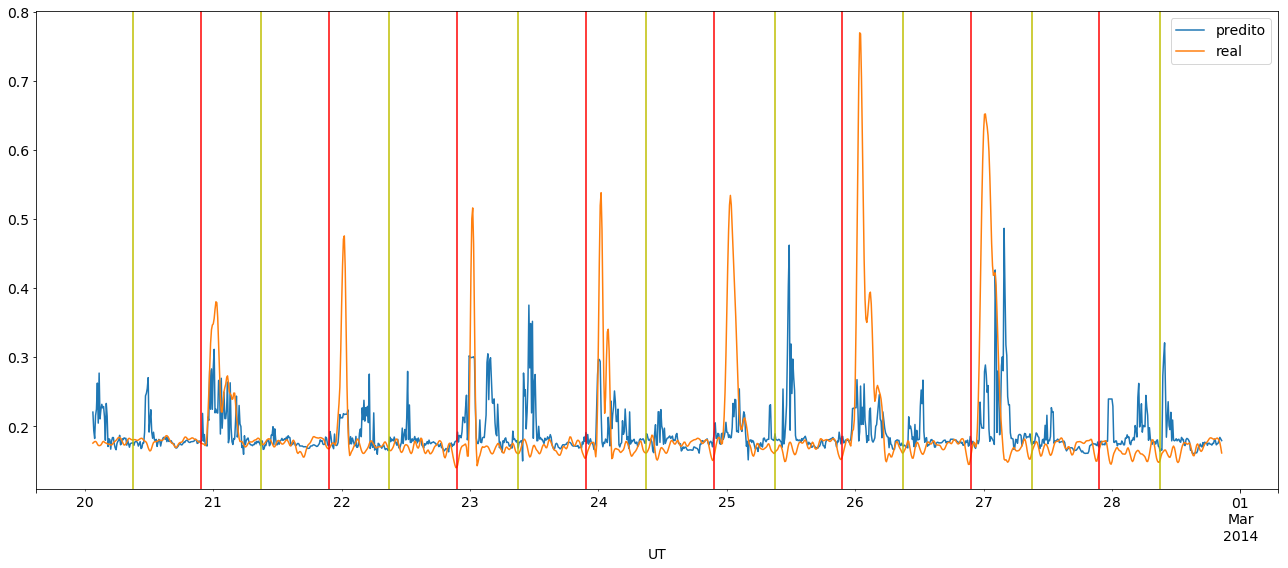

In [6]:
instances_set = ['vtec', 'gvtec1', 'gvtec2']
dict_error = generate_and_avaliate_model(df=df,
                                         instances_set=instances_set,
                                         target='s4')